# Graph Powered Machine Learning - Exercise 2, Task 2

Group (2 Person)

Full Name: Shreyas Srinivasa, Harsh Rajesh Parikh

Student Affiliation: AAU

Email Address: shsr@es.aau.dk, hrp@et.aau.dk

# 2.2 Graph Learning Tasks

Pick one of the following Graph Learning Tasks from the DGL Guide and
create a python tutorial (preferably as jupyter notebook) for that example.
Feel free to choose another dataset (http://kaggle.com is a good starting
point).

1. Node Classication/Regression
2. Edge Classication/Regression
3. Link Prediction
4. Graph Classication

##Example for Node Classification

We use this tutorial we demonstrate the use of Node Classifiction

One of the most popular and widely adopted tasks for graph neural networks is node classification, where each node in the training / validation / test set is assigned a ground truth category from a set of predefined categories. Node regression is similar, where each node in the training / validation / test set is assigned a ground truth number.

**Getting Started**

We demonstrate the node clssification with DGL and PyTorch.

In [ ]:
!pip install torch
!pip install dgl
!pip install networkx

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import networkx as nx
import dgl
from dgl import DGLGraph
import numpy as np

#Load pytorch as a backend
dgl.load_backend('pytorch')

Using backend: pytorch


**GNN Model**


GNN model
Typically, GNN is used to compute meaningful node embeddings. With the embeddings, we can perform many downstream tasks.

DGL provides two ways of implementing a GNN model:

using the nn module, which contains many commonly used GNN modules.
using the message passing interface to implement a GNN model from scratch.
For simplicity, we implement the GNN model in the tutorial with the nn module.

In this tutorial, we use GraphSage, one of the first inductive GNN models. GraphSage performs the following computation on every node $v$ in the graph:

$$h_{N(v)}^{(l)} \gets AGGREGATE_k({h_u^{(l-1)}, \forall u \in N(v)})$$$$h_v^{(l)} \gets \sigma(W^k \cdot CONCAT(h_v^{(l-1)}, h_{N(v)}^{(l)})),$$
where $N(v)$ is the neighborhood of node $v$ and $l$ is the layer Id.

The GraphSage model has multiple layers. In each layer, a vertex accesses its direct neighbors. When we stack $k$ layers in a model, a node $v$ access neighbors within $k$ hops. The output of the GraphSage model is node embeddings that represent the nodes and all information in the k-hop neighborhood.

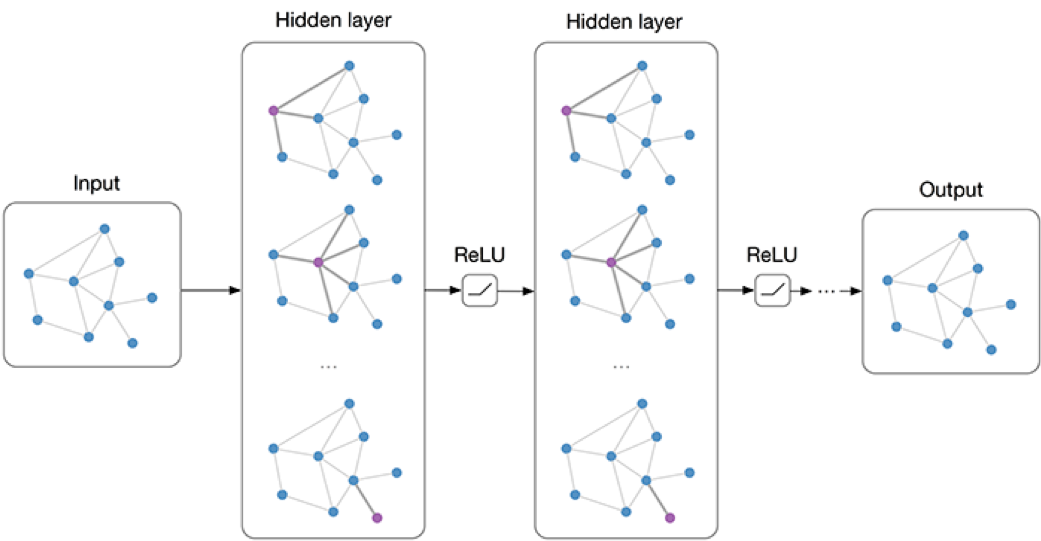



Use DGL's nn module to build the GraphSage model. SAGEConv implements the operations of GraphSage in a layer.


In [ ]:
from dgl.nn.pytorch import conv as dgl_conv

class GraphSAGEModel(nn.Module):
    def __init__(self,
                 in_feats,
                 n_hidden,
                 out_dim,
                 n_layers,
                 activation,
                 dropout,
                 aggregator_type):
        super(GraphSAGEModel, self).__init__()
        self.layers = nn.ModuleList()

        # input layer
        self.layers.append(dgl_conv.SAGEConv(in_feats, n_hidden, aggregator_type,
                                         feat_drop=dropout, activation=activation))
        # hidden layers
        for i in range(n_layers - 1):
            self.layers.append(dgl_conv.SAGEConv(n_hidden, n_hidden, aggregator_type,
                                             feat_drop=dropout, activation=activation))
        # output layer
        self.layers.append(dgl_conv.SAGEConv(n_hidden, out_dim, aggregator_type,
                                         feat_drop=dropout, activation=None))

    def forward(self, g, features):
        h = features
        for layer in self.layers:
            h = layer(g, h)
        return h

##Preparing the dataset

In this tutorial, we use a citation network called pubmed for demonstration. A node in the citation network is a paper and an edge represents the citation between two papers. This dataset has 19,717 papers and 88,651 citations. Each paper has a sparse bag-of-words feature vector and a class label.

All other graph data, such as node features, are stored as NumPy tensors. When we load the tensors, we convert them to Pytorch tensors.

In [ ]:
from dgl.data import citegrh

# load and preprocess the pubmed dataset
data = citegrh.load_pubmed()

# sparse bag-of-words features of papers
features = torch.FloatTensor(data.features)
# the number of input node features
in_feats = features.shape[1]
# class labels of papers
labels = torch.LongTensor(data.labels)
# the number of unique classes on the nodes.
n_classes = data.num_labels

Then we create a DGLGraph from the grpah dataset and convert it to a read-only DGLGraph, which supports more efficient computation. Currently, DGL sampling API only works on read-only DGLGraphs.

In [ ]:
g = DGLGraph(data.graph)
g.readonly()

##Node classification in the semi-supervised setting

Let us perform node classification in a semi-supervised setting. In this setting, we have the entire graph structure and all node features. We only have labels on some of the nodes. We want to predict the labels on other nodes. Even though some of the nodes do not have labels, they connect with nodes with labels. Thus, we train the model with both labeled nodes and unlabeled nodes. Semi-supervised learning can usually improve performance.

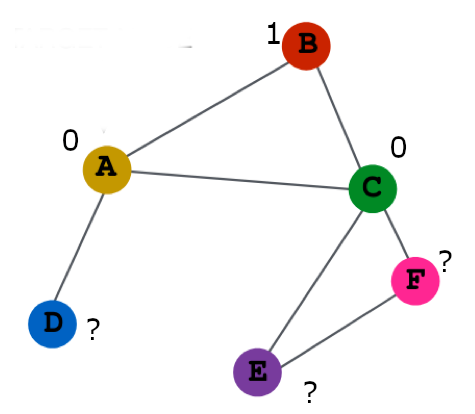

This dependency graph shows a better view of how labeled and unlabled nodes are used in the training.



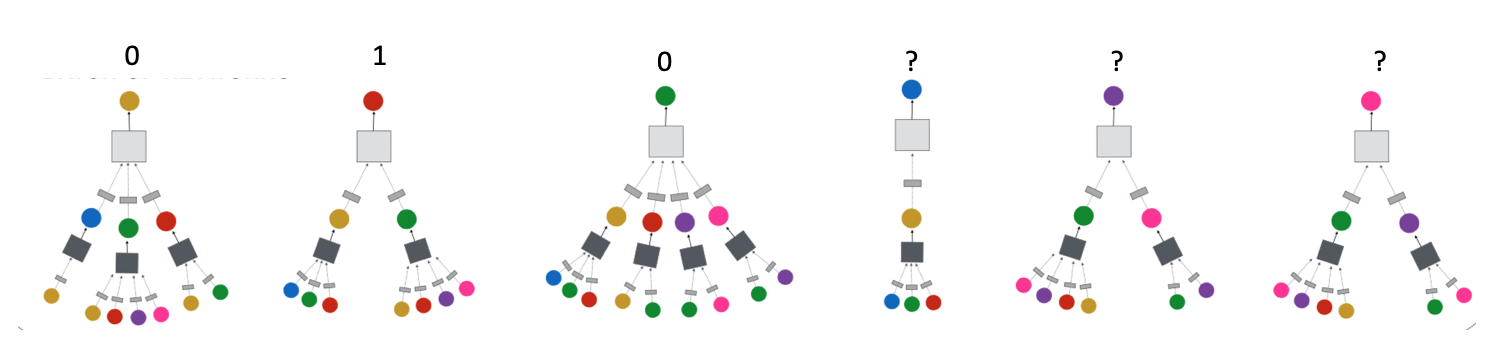

First, we create a 2-layer GraphSage model.

In [ ]:
# Hyperparameters
n_hidden = 64
n_layers = 2
dropout = 0.5
aggregator_type = 'gcn'

gconv_model = GraphSAGEModel(in_feats,
                             n_hidden,
                             n_classes,
                             n_layers,
                             F.relu,
                             dropout,
                             aggregator_type)

Now we create the node classification model based on the GraphSage model. The GraphSage model takes a DGLGraph object and node features as input and computes node embeddings as output. With node embeddings, we use a cross entropy loss to train the node classification model.

Now we create the node classification model based on the GraphSage model. The GraphSage model takes a DGLGraph object and node features as input and computes node embeddings as output. With node embeddings, we use a cross entropy loss to train the node classification model.

In [ ]:
class NodeClassification(nn.Module):
    def __init__(self, gconv_model, n_hidden, n_classes):
        super(NodeClassification, self).__init__()
        self.gconv_model = gconv_model
        self.loss_fcn = torch.nn.CrossEntropyLoss()

    def forward(self, g, features, train_mask):
        logits = self.gconv_model(g, features)
        return self.loss_fcn(logits[train_mask], labels[train_mask])

After defining a model for node classification, we need to define an evaluation function to evaluate the performance of a trained model.

In [ ]:
def NCEvaluate(model, g, features, labels, test_mask):
    model.eval()
    with torch.no_grad():
        # compute embeddings with GNN
        logits = model.gconv_model(g, features)
        logits = logits[test_mask]
        test_labels = labels[test_mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == test_labels)
        return correct.item() * 1.0 / len(test_labels)


Prepare data for semi-supervised node classification

In [ ]:
# the dataset is split into training set, validation set and testing set.
train_mask = torch.BoolTensor(data.train_mask)
val_mask = torch.BoolTensor(data.val_mask)
test_mask = torch.BoolTensor(data.test_mask)

print("""----Data statistics------'
      #Classes %d
      #Train samples %d
      #Val samples %d
      #Test samples %d""" %
          (n_classes,
           data.train_mask.sum().item(),
           data.val_mask.sum().item(),
           data.test_mask.sum().item()))

After defining the model and evaluation function, we can put everything into the training loop to train the model.

In [ ]:
# Node classification task
model = NodeClassification(gconv_model, n_hidden, n_classes)

# Training hyperparameters
weight_decay = 5e-4
n_epochs = 150
lr = 1e-3

# create the Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

dur = []
for epoch in range(n_epochs):
    # Set the model in the training mode.
    model.train()
    # forward
    loss = model(g, features, train_mask)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    acc = NCEvaluate(model, g, features, labels, val_mask)
    print("Epoch {:05d} | Loss {:.4f} | Accuracy {:.4f}"
          .format(epoch, loss.item(), acc))

print()
acc = NCEvaluate(model, g, features, labels, test_mask)
print("Test Accuracy {:.4f}".format(acc))